Best model accuracy: 0.88


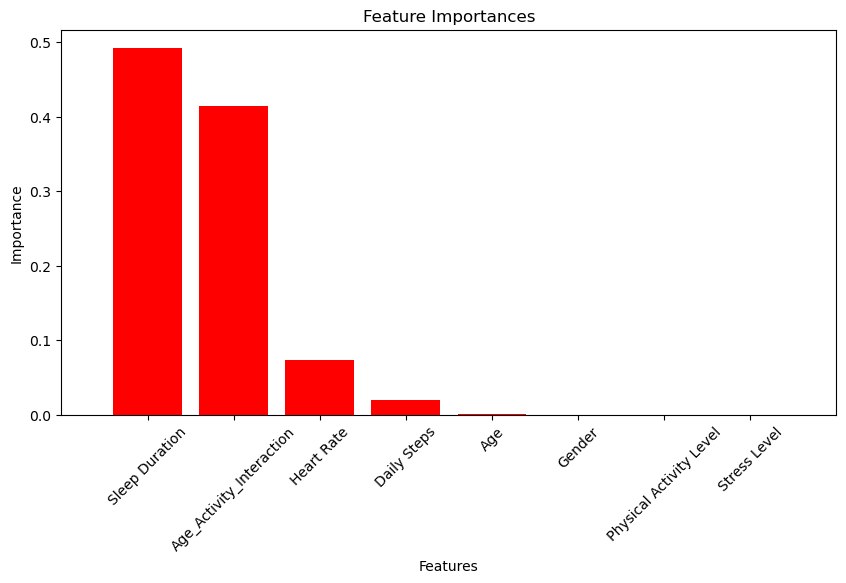

In [3]:
# Decision Tree Project 3
# Sleep health and lifestyle
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Encode Sleep Disorder's to 0,1,2
encoder = LabelEncoder()
df['Sleep Disorder'] = encoder.fit_transform(df['Sleep Disorder'])

# MALE = 0; FEMALE = 0
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')
df[['Age', 'Sleep Duration', 'Stress Level', 'Daily Steps', 'Heart Rate', 'Gender', 'Physical Activity Level']] = imputer.fit_transform(df[['Age', 'Sleep Duration', 'Stress Level', 'Daily Steps', 'Heart Rate', 'Gender', 'Physical Activity Level']])

# Create an interaction term with age and phys activity
df['Age_Activity_Interaction'] = df['Age'] * df['Physical Activity Level']

# Define features and target
features = df[['Age', 'Sleep Duration', 'Stress Level', 'Daily Steps', 'Heart Rate', 'Physical Activity Level', 'Age_Activity_Interaction', 'Gender']]
target = df['Sleep Disorder']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluation
y_pred_best = best_model.predict(X_test)
print("Best model accuracy:", accuracy_score(y_test, y_pred_best))

# Feature Importance Visualization
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


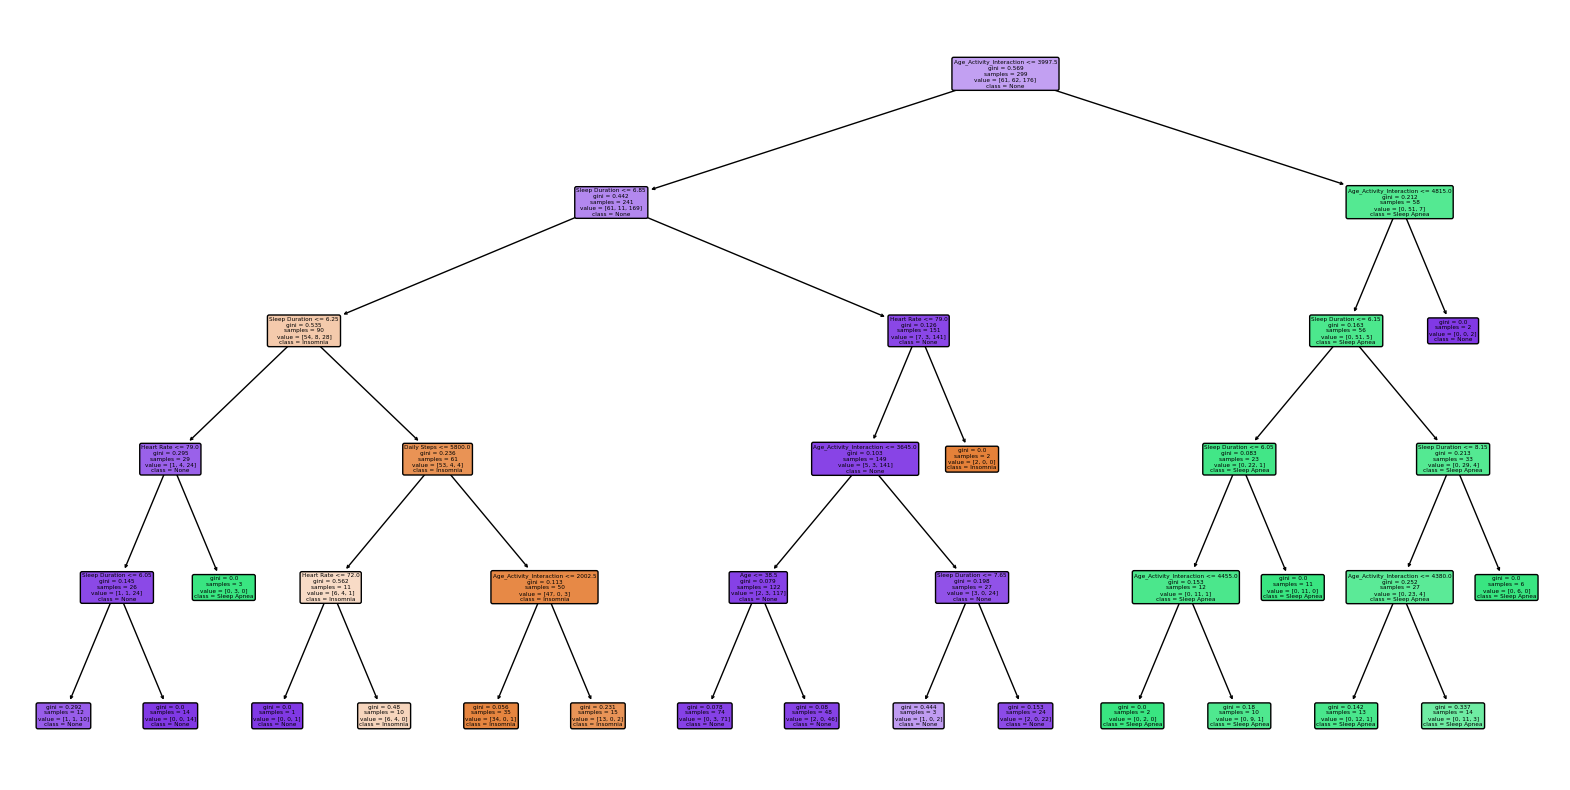

In [4]:
# Visual for decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(best_model, 
          filled=True, 
          rounded=True, 
          class_names=['Insomnia', 'Sleep Apnea', 'None'],
          feature_names=features.columns.tolist())
plt.show()